In [20]:
import numpy as np
import numpy.fft as fp
import matplotlib.pyplot as plt
from PIL import Image
import cv2
%matplotlib inline

# Uploading image and searching for spectrum

Uploading an image "dog.jpg " using the imread function and immediately bring it
to the double type for correct calculations. We will find the image spectrum using
the FFT. We will search for the spectrum of each color channel separately,
and also output the logarithm of the spectrum module for clarity.
We additionally convert the spectrum [0, 1] range.
This is necessary for the correct display of the spectrum, otherwise there will
be a white screen on the graph. Then, we concatenate the obtained spectra.

In [21]:
# Utility functions

remmax = lambda x: x/x.max()
remmin = lambda x: x - np.amin(x, axis=(0, 1), keepdims=True)
touint8 = lambda x: (remmax(remmin(x)) * (256-1e-4)).astype(int)

C:\Users\Maksim Vinogradov\AppData\Local\Temp\ipykernel_3084\3252584836.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  imfft[:, :, i] = fp.fft2(img[:, :, i])


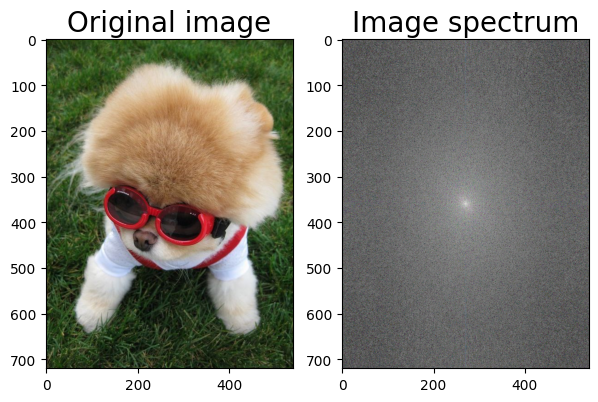

In [22]:
#Loading image
im = Image.open('dog.jpg')
c, r = im.size

img = np.array(im)
imfft = np.zeros((r, c, 3))
for i in range(3):
    imfft[:, :, i] = fp.fft2(img[:, :, i])
imf = touint8(np.log(abs(fp.fftshift(imfft)) + 1))

fig1, axes1 = plt.subplots(1, 2, figsize=(7, 5))
axes1[0].imshow(im)
axes1[0].set_title('Original image', fontsize=20)
axes1[1].imshow(imf)
axes1[1].set_title('Image spectrum', fontsize=20)
plt.show()

# Setting the low pass filter

It is necessary to set a low-pass filter in the form of a Gaussian function.
The cutoff frequency is 0.1 1/pixel. To set a Gaussian filter in matlab, you
need to translate the cutoff frequency into image fractions.
To do this, we find the sizes `r` and `c` of the image by the size function and
multiply the cutoff frequency by the smaller side.

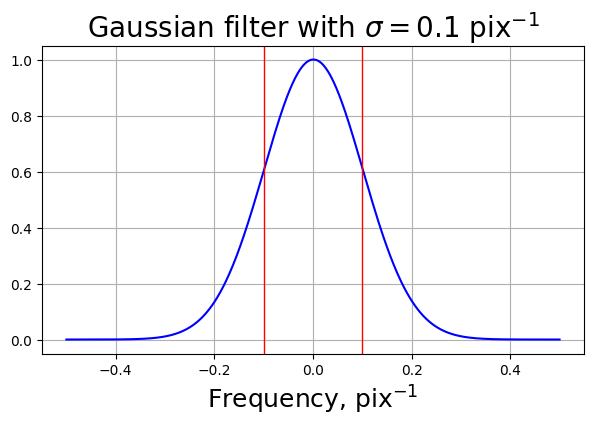

In [23]:
# making gaussian low-pass filter mask
s = 0.1  # sigma in 1/pix
sigma = 0.1 * min(im.size)

def gauss(row, column, std):  
    x, y = np.meshgrid(np.arange(-column/2, column/2), np.arange(-row/2, row/2))
    arg   = -(x ** 2 + y ** 2) / (2 * std ** 2)
    h = np.exp(arg)
    h[h < 2.2204e-16 * np.amax(h)] = 0
    sumh = np.sum(h)
    if sumh:
        h = h / sumh
    return h
    
h = gauss(r, c, sigma)  # gaussian mask
f = np.linspace(-0.5, 0.5, c)  # frequency grid

# graphics
plt.figure(figsize=(7, 4))
norm = np.amax(h[round(r / 2), :]) ** (-1)  # normalizing coefficient
plt.plot(f, norm * h[round(r / 2), :], 'b')
plt.axvline(x=s, color='r', lw=1)
plt.axvline(x=-s, color='r', lw=1)
plt.grid()
plt.title('Gaussian filter with $\sigma = %.1f$ pix$^{-1}$' % (s,), fontsize=20)
plt.xlabel('Frequency, pix$^{-1}$', fontsize=18)
plt.show()

# Filtering in frequency domain

Let's apply the resulting low-pass filter to the image spectrum.
As mentioned above, the spectrum of the image is found using FFT.
We multiply the obtained spectrum by the filter matrix, and then using the
inverse Fourier transform we get the processed image.

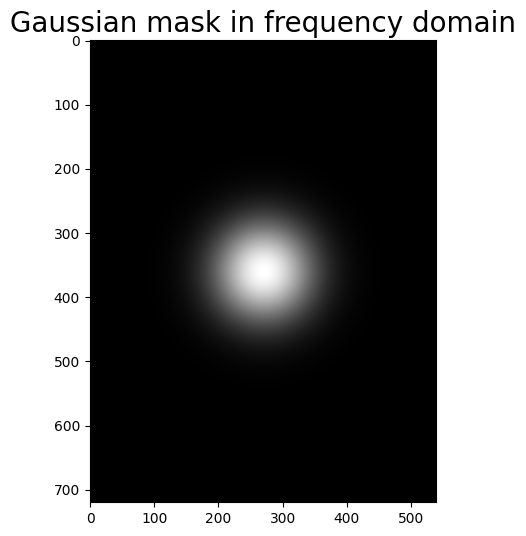

C:\Users\Maksim Vinogradov\AppData\Local\Temp\ipykernel_3084\457963194.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  im1fft[:, :, i] = fp.fftshift(fp.fft2(img[:, :, i])) * h
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


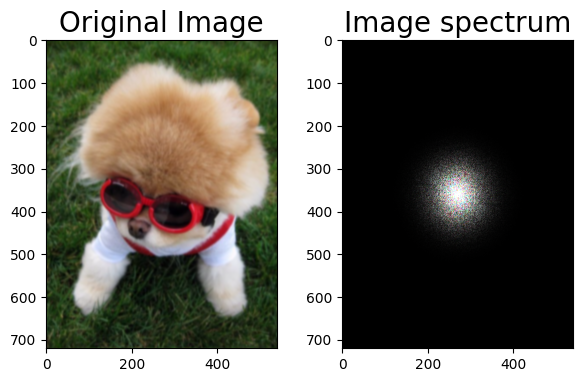

In [24]:
plt.figure(figsize=(10, 6))
plt.imshow(h, cmap='gray')
plt.title('Gaussian mask in frequency domain', fontsize=20)
plt.show()


im1fft = np.zeros((r, c, 3))
im1 = np.zeros((r, c, 3))
for i in range(3):
    im1fft[:, :, i] = fp.fftshift(fp.fft2(img[:, :, i])) * h
    im1[:, :, i] = abs(fp.ifft2(fp.ifftshift(fp.fftshift(fp.fft2(img[:, :, i])) * h)))
im1 = touint8(im1)

fig2, axes2 = plt.subplots(1, 2, figsize=(7, 4))
axes2[0].imshow(im1)
axes2[0].set_title('Original Image', fontsize=20)
axes2[1].imshow(np.log(abs(im1fft) + 1))
axes2[1].set_title('Image spectrum', fontsize=20)
plt.show()

It can be seen that mainly low frequencies remained in the spectrum.
The image, in accordance with this, has become more blurry.

# Setting the spatial filter

We get a mask for spatial filtering. To do this, we will find the inverse
Fourier transform from the low-pass filter obtained above.
Let's cut the resulting mask to the size of 11x11 so that it is symmetrical with
respect to the central element.

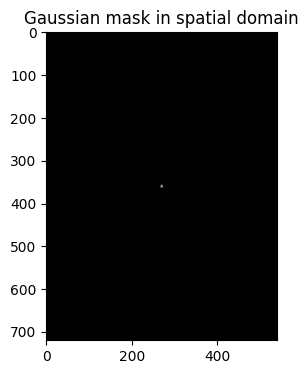

In [25]:
hs = fp.ifftshift(fp.ifft2(h))  # gaussian filter in frequency domain

plt.figure(figsize=(7, 4))
plt.imshow(np.log(abs(hs)+1), cmap='gray')
plt.title('Gaussian mask in spatial domain')
plt.show()

This mask has been normalized so that the sum of all its elements is equal to one.

# Filtering in the spatial domain

Let's apply the resulting mask to the original image.
To do this, it is necessary to perform a convolution operation. By default,
the image is padded with zeros at the edges.

C:\Users\Maksim Vinogradov\AppData\Local\Temp\ipykernel_3084\3083132412.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  im2fft[:, :, i] = fp.fft2(im2[:, :, i])


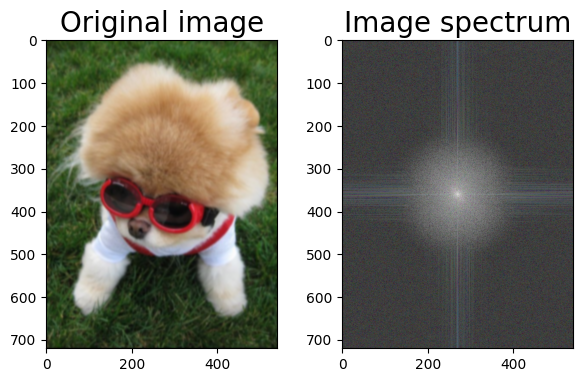

In [26]:

uncut = 11  # size of spatial domain mask
cut = np.floor(uncut/2)  # half-size of spatial domain mask

hs_cut = hs[int(r / 2 - cut) : int(r / 2 + cut + 1), int(c / 2 - cut) : int(c / 2 + cut + 1)]  # cut mask
H = np.sum(abs(hs_cut)) ** (-1) * abs(hs_cut)  # normalized mask

im2 = np.zeros((r,c,3))
im2 = cv2.filter2D(img, ddepth=-1, kernel=H, borderType=cv2.BORDER_CONSTANT)

im2fft = np.zeros((r,c,3))
for i in range(3):
    im2fft[:, :, i] = fp.fft2(im2[:, :, i])

im2fft_shift = touint8(np.log(abs(fp.fftshift(im2fft))+1))

fig3, axes3 = plt.subplots(1, 2, figsize=(7, 4))
axes3[0].imshow(im2)
axes3[0].set_title('Original image', fontsize=20)
axes3[1].imshow(im2fft_shift)
axes3[1].set_title('Image spectrum', fontsize=20)
plt.show()

The image was also blurred, and high frequencies were suppressed in the spectrum.

# Comparison of results

As can be seen, the results obtained by filtering in the frequency domain with a
Gaussian filter and by filtering in the spatial domain with a Fourier image of
the same filter give identical results. The images visually look exactly the same.
The spectra of these images also look the same, but the spectrum of the image
processed in the spatial domain has pronounced vertical and horizontal bands
passing through the center of the spectrum. This is due to the fact that we used
a cropped mask, which does not exactly correspond to the Fourier image of the filter.
This led to the appearance of artifacts in the spectrum.
The visual differences between these images are only at their edges.
The image processed in the spatial domain has darkened edges,
because the addition of zeros was used. This phenomenon can be eliminated by
using the addition of a periodic continuation of the image along the edges.

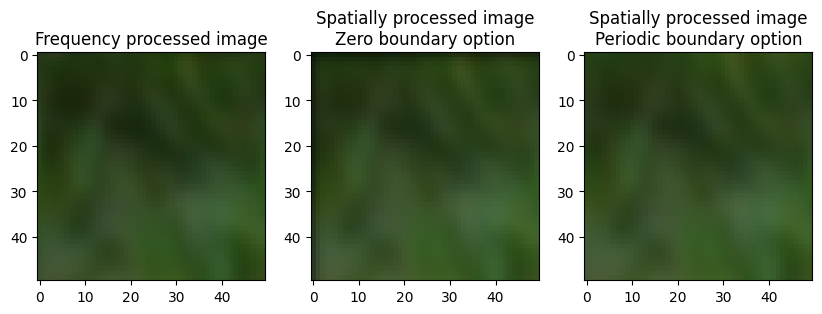

In [27]:
im3 = cv2.filter2D(img, ddepth=-1, kernel=H, borderType=cv2.BORDER_REPLICATE)

plt.figure(figsize=(10, 6))
plt.subplot(131); plt.imshow(im1[0:50, 0:50, :]); plt.title('Frequency processed image')
plt.subplot(132); plt.imshow(im2[0:50, 0:50, :])
plt.title('Spatially processed image\nZero boundary option')
plt.subplot(133); plt.imshow(im3[0:50, 0:50, :])
plt.title('Spatially processed image\nPeriodic boundary option')
plt.show()

It can be seen that the edges are darkened in the middle image corresponding to
the addition of zeros, but when using periodic continuation, this effect is not
observed, and it is visually quite difficult to find any differences from frequency processing.

# Conclusion
In this work, an algorithm for linear image filtering in the frequency domain
and in the spatial domain was implemented, and these two filtering methods were compared.
• application of a low-pass filter in the frequency domain
(multiplication by the image spectrum) is identical to convolution of its Fourier
image with an image in the spatial domain
• however, the results are still different if, when processing in the spatial domain,
not the full Fourier image of the filter is used, but only a fragment of it.
This leads to the appearance of artifacts in the image spectrum, and hence in the image itself.
• when using the addition of zeros, a "frame" appears at the edges of the image
(darkened pixels). To avoid this, it is necessary to use addition by duplicating
values at the edges, periodic repetition of the image and other methods of additions
• calculation of the inverse Fourier transform of the pot filter and cropping,
output of the resulting mask to the screen.